In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore, ttest_ind, mannwhitneyu
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import *

import warnings
from sklearn.exceptions import DataConversionWarning,ConvergenceWarning

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import pdist
from sklearn.utils import resample
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import where

In [3]:
train = pd.read_csv(r'C:\Users\anura\Desktop\Capstone Project\Fraud Detection\Training_Test\UNSW_NB15_testing-set.csv')
train.head(2)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0


In [4]:
dfc = train.copy()

In [5]:
test = pd.read_csv(r'C:\Users\anura\Desktop\Capstone Project\Fraud Detection\Training_Test\UNSW_NB15_training-set.csv')
test.head(2)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0


In [6]:
train.shape, test.shape

((82332, 45), (175341, 45))

In [7]:
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
dfc.drop('id', axis = 1, inplace = True)

In [8]:
df_cat = train.select_dtypes(include = 'object')
df_num = train.select_dtypes(exclude = 'object')

In [9]:
for i in df_cat.columns:
    print(i, df_cat[i].nunique())

proto 131
service 13
state 7
attack_cat 10


In [10]:
for i in ['proto', 'service', 'state']:
    dic = dict(df_cat.groupby(i)['attack_cat'].count()/df_cat.shape[0])
    df_cat[i] = df_cat[i].map(dic)
df_cat

<ipython-input-10-7532b321132e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[i] = df_cat[i].map(dic)


,proto,service,state,attack_cat
0,0.357309,0.572718,0.414942,Normal
1,0.357309,0.572718,0.414942,Normal
2,0.357309,0.572718,0.414942,Normal
3,0.357309,0.572718,0.414942,Normal
4,0.357309,0.572718,0.414942,Normal
...,...,...,...,...
82327,0.357309,0.572718,0.414942,Normal
82328,0.523430,0.572718,0.477809,Normal
82329,0.011988,0.572718,0.414942,Normal
82330,0.011988,0.572718,0.414942,Normal


In [11]:
## here we are doing frequency encoding for categorical columns as if we do label or one hot encoding 
## there are chances of biasing or loosing the actual essence of data

In [12]:
df_cat['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [13]:
atk_lab = {'Normal' : 0, 'Generic' : 1, 'Exploits' : 2, 'Fuzzers' : 3, 'DoS' : 4, 'Reconnaissance' : 5,
          'Analysis' : 6, 'Backdoor' : 7, 'Shellcode' : 8, 'Worms' : 9}
df_cat['attack_label'] = df_cat['attack_cat'].map(atk_lab)

<ipython-input-13-c1c422358285>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['attack_label'] = df_cat['attack_cat'].map(atk_lab)


In [14]:
## here we are doing label encoding

In [15]:
for i in ['proto', 'service', 'state']:
    dic = dict(test.groupby(i)['attack_cat'].count()/test.shape[0])
    test[i] = test[i].map(dic)
test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,0.455946,0.537056,0.443849,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,0.455946,0.537056,0.443849,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,0.455946,0.537056,0.443849,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,0.455946,0.019550,0.443849,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,0.455946,0.537056,0.443849,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,0.360914,0.269726,0.469229,2,0,114,0,111111.107200,254,...,13,24,0,0,0,24,24,0,Generic,1
175337,0.505762,0.455946,0.537056,0.443849,10,8,620,354,33.612649,254,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,0.000009,0.360914,0.269726,0.469229,2,0,114,0,111111.107200,254,...,3,13,0,0,0,3,12,0,Generic,1
175339,0.000009,0.360914,0.269726,0.469229,2,0,114,0,111111.107200,254,...,14,30,0,0,0,30,30,0,Generic,1


In [16]:
test['attack_label'] = test['attack_cat'].map(atk_lab)
test.head(2)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,attack_label
0,0.121478,0.455946,0.537056,0.443849,6,4,258,172,74.087490,252,...,1,0,0,0,1,1,0,Normal,0,0
1,0.649902,0.455946,0.537056,0.443849,14,38,734,42014,78.473372,62,...,2,0,0,0,1,6,0,Normal,0,0


In [17]:
df = pd.concat([df_num, df_cat], axis = 1)
df.head(2)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat,attack_label
0,0.000011,2,0,496,0,90909.0902,254,0,180363632.0,0.0,...,0,1,2,0,0,0.357309,0.572718,0.414942,Normal,0
1,0.000008,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,...,0,1,2,0,0,0.357309,0.572718,0.414942,Normal,0


In [18]:
df['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

## ------------------------ Decision Tree --------------------------------------------

In [62]:
X = df.drop(['attack_cat', 'attack_label'], axis = 1)
Y = df['attack_cat']

In [63]:
X.shape, Y.shape

((175341, 43), (175341,))

In [71]:
Xtest = test.drop(['attack_cat' ,'label'], axis = 1)
Ytest = test['attack_cat']

In [72]:
Xtest.label

AttributeError: 'DataFrame' object has no attribute 'label'

In [73]:
Xtest.shape, Ytest.shape

((82332, 43), (82332,))

In [74]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X, Y)

DecisionTreeClassifier(random_state=0)

In [75]:
dt.score(X,Y)

0.9091142402518521

In [76]:
dt.score(Xtest, Ytest)

0.04246222610892484

## ------------------------------------- Random Forest ---------------------------------------------------

In [87]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [88]:
df_RF = pd.concat([df_num, df_cat], axis = 1)
df_RF.head(2)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat,attack_label
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,0,1,1,0,0,0.455946,0.537056,0.443849,Normal,0
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,0,1,6,0,0,0.455946,0.537056,0.443849,Normal,0


In [90]:
df_RF.shape

(175341, 45)

In [18]:
X_RF = df_RF.drop(['attack_cat', 'attack_label'], axis = 1)
Y_RF = df_RF['attack_label']

In [19]:
Xtest_RF = test.drop(['attack_cat', 'attack_label'], axis = 1)
Ytest_RF = test['attack_label']

In [47]:
RF = RandomForestClassifier()
param = {'n_estimators' : [100, 150, 200, 250], 'criterion' : ['entropy', 'gini'], 'max_depth' : range(1,11), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 11),
                         'n_estimators': [100, 150, 200, 250], 'n_jobs': [-1]},
             scoring='f1_weighted')

In [48]:
GS.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 150, 'n_jobs': -1}

In [49]:
RF = RandomForestClassifier()
param = {'n_estimators' : [100, 150, 200, 250], 'criterion' : ['entropy', 'gini'], 'max_depth' : range(10,20), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(10, 20),
                         'n_estimators': [100, 150, 200, 250], 'n_jobs': [-1]},
             scoring='f1_weighted')

In [50]:
GS.best_params_

{'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 100, 'n_jobs': -1}

In [51]:
RF = RandomForestClassifier()
param = {'n_estimators' : [80, 100, 150, 200], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : range(2,6), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': range(2, 6),
                         'n_estimators': [80, 100, 150, 200], 'n_jobs': [-1]},
             scoring='f1_weighted')

In [52]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}

In [19]:
RF = RandomForestClassifier()
param = {'n_estimators' : [200, 220, 250, 280, 300], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : range(2,4), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': range(2, 4),
                         'n_estimators': [200, 220, 250, 280, 300],
                         'n_jobs': [-1]},
             scoring='f1_weighted')

In [20]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 300, 'n_jobs': -1}

In [22]:
RF = RandomForestClassifier()
param = {'n_estimators' : [300, 320, 350, 380, 400], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : [2], 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': [2],
                         'n_estimators': [300, 320, 350, 380, 400],
                         'n_jobs': [-1]},
             scoring='f1_weighted')

In [23]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 320, 'n_jobs': -1}

In [20]:
RF = RandomForestClassifier(n_estimators = 320, criterion = 'gini', min_samples_leaf = 2, n_jobs = -1)
RF.fit(X_RF, Y_RF)

RandomForestClassifier(min_samples_leaf=2, n_estimators=320, n_jobs=-1)

In [21]:
RF.score(X_RF, Y_RF)

0.9035137246850423

In [22]:
RF.score(Xtest_RF, Ytest_RF)

0.12924500801632416

In [25]:
pt = PowerTransformer()
xtn = pt.fit_transform(X_RF)
xtt = pt.transform(Xtest_RF)

In [26]:
RF = RandomForestClassifier()
param = {'n_estimators' : [200, 250, 280, 300, 320, 350], 'criterion' : ['entropy', 'gini'], 'min_samples_leaf' : [2], 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(xtn, Y_RF)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'min_samples_leaf': [2],
                         'n_estimators': [200, 250, 280, 300, 320, 350],
                         'n_jobs': [-1]},
             scoring='f1_weighted')

In [27]:
GS.best_params_

{'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 320, 'n_jobs': -1}

In [28]:
RF = RandomForestClassifier(n_estimators = 320, criterion = 'gini', min_samples_leaf = 2, n_jobs = -1)
RF.fit(xtn, Y_RF)

RandomForestClassifier(min_samples_leaf=2, n_estimators=320, n_jobs=-1)

In [29]:
RF.score(xtn, Y_RF)

0.9035935691024917

In [30]:
RF.score(xtt, Ytest_RF)

0.14287275907302144

## ---------------------------------------------------------------------------------------------

In [19]:
atk_lab

{'Normal': 0,
 'Generic': 1,
 'Exploits': 2,
 'Fuzzers': 3,
 'DoS': 4,
 'Reconnaissance': 5,
 'Analysis': 6,
 'Backdoor': 7,
 'Shellcode': 8,
 'Worms': 9}

In [20]:
df['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [21]:
df['attack_label'] = df['attack_label'].replace({9 : 4, 6 : 5, 8 : 7})
test['attack_label'] = test['attack_label'].replace({9 : 4, 6 : 5, 8 : 7})

In [22]:
df['attack_label'] = df['attack_label'].replace({7:6})
test['attack_label'] = test['attack_label'].replace({7:6})

In [23]:
df['attack_label'].value_counts()

0    37000
1    18871
2    11132
3     6062
5     4173
4     4133
6      961
Name: attack_label, dtype: int64

In [24]:
Xtrain = df.drop(['attack_cat', 'attack_label'], axis = 1)
Ytrain = df['attack_label']
Xtest = test.drop(['attack_cat', 'attack_label'], axis = 1)
Ytest = test['attack_label']

In [25]:
Xtr_cols = Xtrain.columns
Xtest = Xtest.loc[:, Xtr_cols]

In [26]:
Xtrain.shape, Xtest.shape

((82332, 43), (175341, 43))

In [24]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(Xtrain, Ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
xgb.score(Xtrain, Ytrain)

0.8913887795780793

In [26]:
xgb.score(Xtest, Ytest)

0.8870062673079726

In [27]:
ypred_train = xgb.predict(Xtrain)
ypred_test = xgb.predict(Xtest)

In [28]:
pd.Series(ypred_train).value_counts()

0    56000
2    50585
1    39549
3    16808
5     9248
6     1660
4     1491
dtype: int64

In [29]:
pd.Series(ypred_test).value_counts()

0    37000
1    18367
2    15364
3     4919
5     3608
6     2269
4      805
dtype: int64

In [30]:
confusion_matrix(Ytrain, ypred_train)

array([[56000,     0,     0,     0,     0,     0,     0],
       [    0, 39515,   442,    18,    12,     2,    11],
       [    0,    18, 32704,   180,    83,   307,   101],
       [    0,     8,  1607, 16490,     5,    17,    57],
       [    0,     8, 10821,    64,  1376,    50,    75],
       [    0,     0,  3594,     4,    11,  8839,    43],
       [    0,     0,  1417,    52,     4,    33,  1373]], dtype=int64)

In [31]:
confusion_matrix(Ytest, ypred_test)

array([[37000,     0,     0,     0,     0,     0,     0],
       [    0, 18322,   464,    28,    26,     4,    27],
       [    0,    21,  9647,   244,   174,   400,   646],
       [    0,     9,  1108,  4370,    98,    86,   391],
       [    0,    14,  2751,   113,   415,   212,   628],
       [    0,     1,   998,    74,    50,  2874,   176],
       [    0,     0,   396,    90,    42,    32,   401]], dtype=int64)

In [32]:
# Accuracy
print('Train Accuracy\t:', accuracy_score(Ytrain, ypred_train))
print('Test Accuracy \t:', accuracy_score(Ytest, ypred_test))

Train Accuracy	: 0.8913887795780793
Test Accuracy 	: 0.8870062673079726


In [33]:
# Precision
print('Train Precision\t:', precision_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Precision \t:', precision_score(Ytest, ypred_test, average = 'weighted'))

Train Precision	: 0.9190808685935375
Test Precision 	: 0.8966685163233752


In [34]:
# Recall
print('Train Recall\t:', recall_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Recall \t:', recall_score(Ytest, ypred_test, average = 'weighted'))

Train Recall	: 0.8913887795780793
Test Recall 	: 0.8870062673079726


In [35]:
# F1 Score
print('Train f1 score\t:', f1_score(Ytrain, ypred_train, average = 'weighted'))
print('Test f1 score \t:', f1_score(Ytest, ypred_test, average = 'weighted'))

Train f1 score	: 0.8739662083916955
Test f1 score 	: 0.8807875830346257


In [ ]:
# PRECISION RECALL FOR EACH INDIVIDUAL CLASS BY CLASSIFICATION REPORT

In [34]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(Xtest.drop('label', axis = 1), Ytest)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
ypred_ts = xgb.predict(Xtest.drop('label', axis = 1))
print(classification_report(Ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     56000
           1       1.00      0.99      0.99     40000
           2       0.65      0.96      0.77     33393
           3       0.82      0.80      0.81     18184
           4       0.70      0.13      0.23     12394
           5       0.95      0.69      0.80     12491
           6       0.81      0.48      0.60      2879

    accuracy                           0.86    175341
   macro avg       0.84      0.71      0.74    175341
weighted avg       0.87      0.86      0.84    175341



In [37]:
ypred_tr = xgb.predict(Xtrain.drop('label', axis = 1))
print(classification_report(Ytrain, ypred_tr))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85     37000
           1       1.00      0.97      0.98     18871
           2       0.60      0.86      0.71     11132
           3       0.31      0.59      0.41      6062
           4       0.52      0.11      0.18      4133
           5       0.77      0.68      0.72      4173
           6       0.15      0.41      0.22       961

    accuracy                           0.77     82332
   macro avg       0.62      0.62      0.58     82332
weighted avg       0.83      0.77      0.78     82332



In [128]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)

In [131]:
RF_ve = []
for i in [30, 50, 70, 90, 100, 120, 150]:
    print('Estimators:', i)
    RF = RandomForestClassifier(n_estimators = i, criterion = 'gini', min_samples_leaf = 2,
                                random_state = 0, n_jobs = -1)
    score = cross_val_score(RF, Xtrain, Ytrain, cv = kf, scoring = 'f1_weighted')
    RF_ve.append(np.std(score, ddof = 1))

Estimators: 30
Estimators: 50
Estimators: 70
Estimators: 90
Estimators: 100
Estimators: 120
Estimators: 150


In [132]:
RF_ve

[0.0016698294379546208,
 0.0017922672069872736,
 0.0015381311603907234,
 0.0015258795935522854,
 0.0015146774448038032,
 0.0014256054062656794,
 0.0015782141129033372]

In [ ]:
np.min(RF_ve), np.argmin(RF_ve)

In [135]:
RF_ve = []
for i in [30, 50, 70, 90, 100, 120, 150]:
    print('Estimators:', i)
    RF = RandomForestClassifier(n_estimators = i, criterion = 'entropy', min_samples_leaf = 2,
                                random_state = 0, n_jobs = -1)
    score = cross_val_score(RF, Xtrain, Ytrain, cv = kf, scoring = 'f1_weighted')
    RF_ve.append(np.std(score, ddof = 1))

Estimators: 30
Estimators: 50
Estimators: 70
Estimators: 90
Estimators: 100
Estimators: 120
Estimators: 150


In [136]:
RF_ve

[0.001541637704575045,
 0.0018272541475145277,
 0.0017674244712371757,
 0.0019505149670482496,
 0.0018696519396394604,
 0.00173091691647347,
 0.0016975117155327507]

In [138]:
np.min(RF_ve), np.argmin(RF_ve)

(0.001541637704575045, 0)

In [37]:
RF = RandomForestClassifier(n_estimators = 120, criterion = 'gini', min_samples_leaf = 2,
                           random_state = 0, n_jobs = -1)
ada = AdaBoostClassifier(random_state = 0)
ada.fit(Xtrain, Ytrain)

AdaBoostClassifier(random_state=0)

In [38]:
ada.score(Xtrain, Ytrain)

0.8286538801535294

In [39]:
ada.score(Xtest, Ytest)

0.7887698586211922

In [40]:
ypred_train = ada.predict(Xtrain)
ypred_test = ada.predict(Xtest)

In [41]:
pd.Series(ypred_train).value_counts()

0    56000
2    49324
1    39138
3    18994
5    11394
4      480
6       11
dtype: int64

In [42]:
pd.Series(ypred_test).value_counts()

0    37000
2    17381
1    13436
3    10102
5     4268
4      133
6       12
dtype: int64

In [43]:
confusion_matrix(Ytrain, ypred_train)

array([[56000,     0,     0,     0,     0,     0,     0],
       [    0, 37498,   746,  1721,    11,    24,     0],
       [    0,   436, 29559,  1554,   202,  1637,     5],
       [    0,   833,  2335, 14328,    28,   660,     0],
       [    0,   228, 11235,   344,   175,   411,     1],
       [    0,    75,  3765,   877,    42,  7732,     0],
       [    0,    68,  1684,   170,    22,   930,     5]], dtype=int64)

In [44]:
confusion_matrix(Ytest, ypred_test)

array([[37000,     0,     0,     0,     0,     0,     0],
       [    0, 12205,   595,  6046,     5,    19,     1],
       [    0,   273,  9722,   496,    66,   570,     5],
       [    0,   517,  2005,  3140,     3,   397,     0],
       [    0,   216,  3573,   139,    48,   155,     2],
       [    0,   113,   998,   228,    10,  2823,     1],
       [    0,   112,   488,    53,     1,   304,     3]], dtype=int64)

In [45]:
# Accuracy
print('Train Accuracy\t:', accuracy_score(Ytrain, ypred_train))
print('Test Accuracy \t:', accuracy_score(Ytest, ypred_test))

Train Accuracy	: 0.8286538801535294
Test Accuracy 	: 0.7887698586211922


In [46]:
# Precision
print('Train Precision\t:', precision_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Precision \t:', precision_score(Ytest, ypred_test, average = 'weighted'))

Train Precision	: 0.811883156595748
Test Precision 	: 0.8106807023558884


In [47]:
# Recall
print('Train Recall\t:', recall_score(Ytrain, ypred_train, average = 'weighted'))
print('Test Recall \t:', recall_score(Ytest, ypred_test, average = 'weighted'))

Train Recall	: 0.8286538801535294
Test Recall 	: 0.7887698586211922


In [48]:
# F1 Score
print('Train f1 score\t:', f1_score(Ytrain, ypred_train, average = 'weighted'))
print('Test f1 score \t:', f1_score(Ytest, ypred_test, average = 'weighted'))

Train f1 score	: 0.7997122704229718
Test f1 score 	: 0.7784931219435302


In [38]:
RF = RandomForestClassifier(n_estimators = 120, criterion = 'gini', min_samples_leaf = 2,
                           random_state = 0, n_jobs = -1)
ada = AdaBoostClassifier(random_state = 0)
ada.fit(Xtest.drop('label', axis = 1), Ytest)

AdaBoostClassifier(random_state=0)

In [39]:
ypred_ts = ada.predict(Xtest.drop('label', axis = 1))
print(classification_report(Ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     56000
           1       0.95      0.95      0.95     40000
           2       0.69      0.55      0.61     33393
           3       0.57      0.64      0.61     18184
           4       0.29      0.02      0.03     12394
           5       0.31      0.84      0.45     12491
           6       0.62      0.12      0.21      2879

    accuracy                           0.72    175341
   macro avg       0.62      0.57      0.53    175341
weighted avg       0.74      0.72      0.71    175341



In [40]:
ypred_tr = ada.predict(Xtrain.drop('label', axis = 1))
print(classification_report(Ytrain, ypred_tr))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79     37000
           1       0.92      0.90      0.91     18871
           2       0.61      0.63      0.62     11132
           3       0.23      0.49      0.32      6062
           4       0.24      0.01      0.02      4133
           5       0.35      0.81      0.49      4173
           6       0.36      0.12      0.18       961

    accuracy                           0.69     82332
   macro avg       0.51      0.52      0.47     82332
weighted avg       0.74      0.69      0.70     82332



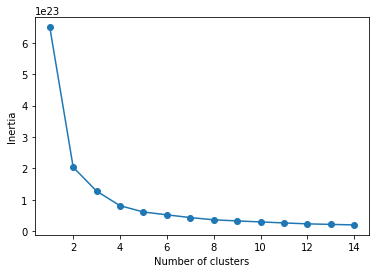

In [65]:
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(Xtrain)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,15), wcss, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [66]:
for i in range(1,12):
    print('Moving from', i, 'clusters to', i+1, 'clusters\t:', wcss[i] - wcss[i-1])

Moving from 1 clusters to 2 clusters	: -4.459625905597795e+23
Moving from 2 clusters to 3 clusters	: -7.61553933131612e+22
Moving from 3 clusters to 4 clusters	: -4.642513251450458e+22
Moving from 4 clusters to 5 clusters	: -2.0066997166230563e+22
Moving from 5 clusters to 6 clusters	: -9.004353147282248e+21
Moving from 6 clusters to 7 clusters	: -8.721162537074373e+21
Moving from 7 clusters to 8 clusters	: -7.125502127040507e+21
Moving from 8 clusters to 9 clusters	: -3.549009426629754e+21
Moving from 9 clusters to 10 clusters	: -3.219202136845509e+21
Moving from 10 clusters to 11 clusters	: -3.2053884106723903e+21
Moving from 11 clusters to 12 clusters	: -2.96057196442968e+21


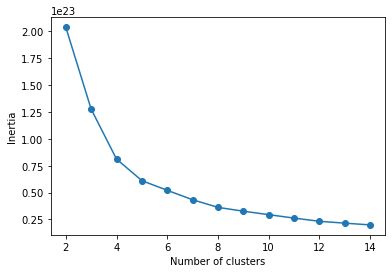

In [67]:
wcss = []
for i in range(2,15):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(Xtrain)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(2,15), wcss, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [68]:
for i in range(1,12):
    print('Moving from', i+1, 'clusters to', i+2, 'clusters\t:', wcss[i] - wcss[i-1])

Moving from 2 clusters to 3 clusters	: -7.615539331316114e+22
Moving from 3 clusters to 4 clusters	: -4.64251325145046e+22
Moving from 4 clusters to 5 clusters	: -2.0066997166230555e+22
Moving from 5 clusters to 6 clusters	: -9.00435314728224e+21
Moving from 6 clusters to 7 clusters	: -8.721162537074365e+21
Moving from 7 clusters to 8 clusters	: -7.125502127040507e+21
Moving from 8 clusters to 9 clusters	: -3.5490094266297667e+21
Moving from 9 clusters to 10 clusters	: -3.2192021368454964e+21
Moving from 10 clusters to 11 clusters	: -3.205388410672403e+21
Moving from 11 clusters to 12 clusters	: -2.96057196442968e+21
Moving from 12 clusters to 13 clusters	: -1.7360565480587012e+21


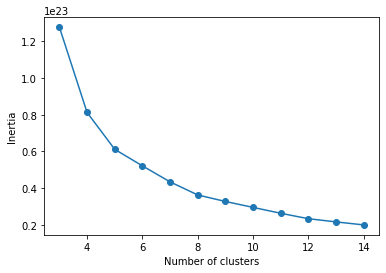

In [69]:
plt.plot(range(3,15), wcss[1:], marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [73]:
Z = linkage(Xtrain, 'ward')
dendrogram(Z, leaf_rotation = 90, truncate_mode = 'level', p = 5)
plt.show()

MemoryError: Unable to allocate 115. GiB for an array with shape (15372145470,) and data type float64

In [74]:
Z = linkage(Xtest, 'ward')
dendrogram(Z, leaf_rotation = 90, truncate_mode = 'level', p = 5)
plt.show()

MemoryError: Unable to allocate 25.3 GiB for an array with shape (3389237946,) and data type float64

In [75]:
Xtest.shape

(82332, 43)

### feature selection through backward elimination

In [82]:
df.attack_label .unique()

array([0, 6, 5, 3, 2, 4, 1], dtype=int64)

In [83]:
test.attack_label .unique()

array([0, 5, 6, 4, 2, 3, 1], dtype=int64)

In [101]:
df.columns


Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label', 'proto',
       'service', 'state', 'attack_cat', 'attack_label'],
      dtype='object')

In [103]:
X_RF = df.drop(['attack_cat', 'attack_label' ,'label'], axis = 1)
Y_RF = df['attack_label']

In [93]:
RF = RandomForestClassifier()
param = {'n_estimators' : [100, 150, 200, 250], 'criterion' : ['entropy', 'gini'], 'max_depth' : range(10,20), 'n_jobs' : [-1]}
GS = GridSearchCV(RF, param, cv = kf, n_jobs = -1, scoring = 'f1_weighted')
GS.fit(X_RF, Y_RF)

KeyboardInterrupt: 

In [ ]:
# GS.best_params_

In [ ]:
# RF = RandomForestClassifier(n_estimators = 320, criterion = 'gini', min_samples_leaf = 2, n_jobs = -1)
# RF.fit(xtn, Y_RF)

In [94]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [173]:
rf = RandomForestClassifier()
back_mod = sfs(estimator = rf ,k_features = 'best' , forward = False ,scoring = 'r2',n_jobs =-1 )
back_feat = back_mod.fit(X_RF, Y_RF)
backward_feature = list(back_feat.k_feature_names_)
print(backward_feature)
print(back_feat.k_score_)## taking too much time
## RESAMPLE AND THEN RUN THE BACKWARD ELMINA 

KeyboardInterrupt: 

In [ ]:
## feature selection using random forest

In [106]:
from sklearn.feature_selection import SelectFromModel

In [152]:
sel = SelectFromModel( RandomForestClassifier())
sel.fit(X_RF, Y_RF)

SelectFromModel(estimator=RandomForestClassifier())

In [153]:
sel.get_support()

array([False, False, False,  True,  True,  True,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
        True,  True,  True,  True,  True,  True, False, False, False,
       False,  True, False, False,  True, False])

In [154]:
## making a list of features

In [155]:
selected_feat = X_RF.columns[(sel.get_support())]
len(selected_feat)

15

In [158]:
## as we can see we get 16 features ,15 features when we dont define n estimators =100

In [159]:
# now to fet the name of 16 features , 15 feature name

In [160]:
print(selected_feat)

Index(['sbytes', 'dbytes', 'rate', 'sttl', 'sload', 'dload', 'smean',
       'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_srv_dst', 'service'],
      dtype='object')


In [161]:
# now using these feature lets build the model 

In [162]:
xsf = df[selected_feat]

In [163]:
ysf = df['attack_label']

In [164]:
rf = RandomForestClassifier()

In [165]:
rf.fit(xsf, ysf)

RandomForestClassifier()

In [166]:
rf.score(xsf , ysf)  # sore is 0.905920463553875 whem we use n_estimator 100

0.9052703018689296

In [131]:
test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,attack_label
0,0.000011,0.357309,0.572718,0.414942,2,0,496,0,90909.090200,254,...,2,0,0,0,1,2,0,Normal,0,0
1,0.000008,0.357309,0.572718,0.414942,2,0,1762,0,125000.000300,254,...,2,0,0,0,1,2,0,Normal,0,0
2,0.000005,0.357309,0.572718,0.414942,2,0,1068,0,200000.005100,254,...,3,0,0,0,1,3,0,Normal,0,0
3,0.000006,0.357309,0.572718,0.414942,2,0,900,0,166666.660800,254,...,3,0,0,0,2,3,0,Normal,0,0
4,0.000010,0.357309,0.572718,0.414942,2,0,2126,0,100000.002500,254,...,3,0,0,0,2,3,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,0.357309,0.572718,0.414942,2,0,104,0,200000.005100,254,...,2,0,0,0,2,1,0,Normal,0,0
82328,1.106101,0.523430,0.572718,0.477809,20,8,18062,354,24.410067,254,...,1,0,0,0,3,2,0,Normal,0,0
82329,0.000000,0.011988,0.572718,0.414942,1,0,46,0,0.000000,0,...,1,0,0,0,1,1,1,Normal,0,0
82330,0.000000,0.011988,0.572718,0.414942,1,0,46,0,0.000000,0,...,1,0,0,0,1,1,1,Normal,0,0


In [167]:
xsct =test[selected_feat]
xsct.shape

(82332, 15)

In [168]:
ysct = test['attack_label']


In [169]:
rf.score(xsct , ysct)  ## score is still the same , hence n_estimator is not creating much of a 
# impact

0.7650609726473303

In [170]:
ypred = rf.predict(xsct)

In [171]:
confusion_matrix(ysct, ypred)

array([[28070,     8,   673,  7534,    59,   522,   134],
       [    7, 18353,   387,    55,    37,     4,    28],
       [  101,    11,  9190,   480,   223,   502,   625],
       [  884,     3,  1030,  3587,    23,   142,   393],
       [   33,    12,  2448,   264,   562,   266,   548],
       [   30,     0,   909,   159,    34,  2871,   170],
       [    9,     0,   355,   154,    21,    66,   356]], dtype=int64)

In [ ]:
# array([[28077,     8,   657,  7550,    57,   520,   131],
#        [   10, 18364,   404,    29,    36,     3,    25],
#        [  101,    16,  9285,   329,   268,   553,   580],
#        [  899,     5,  1265,  3365,    29,   123,   376],
#        [   23,    17,  2388,   140,   647,   369,   549],
#        [   22,     0,   986,    80,    54,  2872,   159],
#        [    9,     0,   469,    73,    16,    44,   350]], dtype=int64) on nestimato -100

In [140]:
## applying xgb for selection lets find 

In [141]:
sel = SelectFromModel(XGBClassifier(random_state = 0))
sel.fit(X_RF, Y_RF)

SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=None, max_delta_step=None,
                                        max_depth=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None, random_state=0,
                                        reg_alpha=None, reg_lambda=None,
                                        scale_pos_weight=None, subsample=None,
                                     

In [142]:
#list
selected_feat = X_RF.columns[(sel.get_support())]
len(selected_feat)

6

In [143]:
sel.get_support()

array([False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True,  True,  True, False, False])

In [144]:
print(selected_feat)

Index(['sttl', 'dttl', 'ct_dst_sport_ltm', 'ct_srv_dst', 'is_sm_ips_ports',
       'proto'],
      dtype='object')


In [145]:
xscx = df[selected_feat]
xscx

,sttl,dttl,ct_dst_sport_ltm,ct_srv_dst,is_sm_ips_ports,proto
0,252,254,1,1,0,0.455946
1,62,252,1,6,0,0.455946
2,62,252,1,6,0,0.455946
3,62,252,1,1,0,0.455946
4,254,252,1,39,0,0.455946
...,...,...,...,...,...,...
175336,254,0,13,24,0,0.360914
175337,254,252,1,1,0,0.455946
175338,254,0,3,12,0,0.360914
175339,254,0,14,30,0,0.360914


In [146]:
yscx = df['attack_label']
yscx

0         0
1         0
2         0
3         0
4         0
         ..
175336    1
175337    6
175338    1
175339    1
175340    1
Name: attack_label, Length: 175341, dtype: int64

In [148]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(xscx ,yscx)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [149]:
xgb.score(xscx , yscx)

0.7625369993327288

In [150]:
xt1 = test[selected_feat]
yt1 = test['attack_label']

In [151]:
xgb.score(xt1 , yt1)

0.6675290288101832

In [ ]:
### feature selection on xgb is giving very poor result

## ----------------------------------------------------------------------------------------

In [19]:
dfr = resample(df, n_samples = 30000, replace = False, stratify = df['attack_cat'], random_state = 0)
dfr.head(2)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto,service,state,attack_cat,attack_label
30366,0.001149,2,2,146,178,2610.966017,31,29,5.082681e+05,619669.25,...,0,5,3,0,0,0.357309,0.259522,0.084803,Normal,0
45587,0.000012,2,0,1064,0,83333.330390,254,0,3.546667e+08,0.00,...,0,1,2,0,1,0.357309,0.572718,0.414942,Fuzzers,3


In [20]:
dfr['attack_label'].value_counts()

0    13482
1     6876
2     4056
3     2209
4     1490
5     1274
6      247
7      212
8      138
9       16
Name: attack_label, dtype: int64

In [21]:
X,y = make_classification(n_samples = 500, n_features = 2, n_redundant = 0,
                          n_clusters_per_class = 1, weights = [0.99], flip_y = 0,
                         random_state = 0)

In [22]:
cnt = Counter(y)
cnt

Counter({0: 495, 1: 5})

In [23]:
pd.DataFrame(X).head(2)

,0,1
0,0.915159,-1.231582
1,0.339726,-1.839427


In [24]:
cnt.items()

dict_items([(0, 495), (1, 5)])

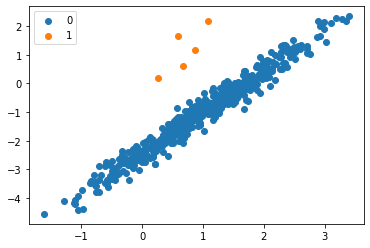

In [25]:
for label, _ in cnt.items():
    row_ix = where(y == label)
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label = str(label))
plt.legend()
plt.show()

In [26]:
where(y == 1)

(array([ 54, 317, 331, 385, 457], dtype=int64),)

In [29]:
a,b = make_classification(n_samples = 500, n_features = 2, n_redundant = 0,
                          n_clusters_per_class = 2, weights = [0.98, 0.03], flip_y = 0,
                         random_state = 0)

In [30]:
Counter(b)

Counter({0: 490, 1: 10})

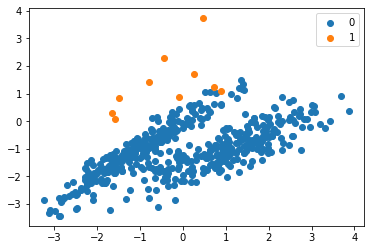

In [31]:
for label, _ in Counter(b).items():
    row_ix = where(b == label)
    plt.scatter(a[row_ix,0], a[row_ix,1], label = str(label))
plt.legend()
plt.show()

In [37]:
oversample = SMOTE(sampling_strategy = 0.1, k_neighbors = 4)
X,y = oversample.fit_resample(X, y)
Counter(y)

Counter({0: 495, 1: 49})

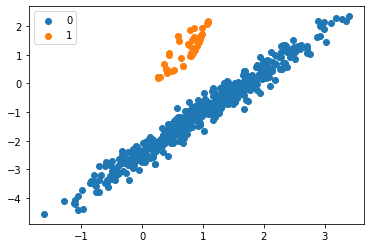

In [38]:
for label, _ in cnt.items():
    row_ix = where(y == label)
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label = str(label))
plt.legend()
plt.show()

In [39]:
under = RandomUnderSampler(sampling_strategy = 0.5)
X,y = under.fit_resample(X,y)
Counter(y)

Counter({0: 98, 1: 49})

In [42]:
X,y = make_classification(n_samples = 1000, n_features = 2, n_redundant = 0, n_classes = 4,
                          n_clusters_per_class = 1, weights = [0.45, 0.35, 0.15, 0.05], flip_y = 0,
                         random_state = 0)

In [43]:
Counter(y)

Counter({0: 450, 2: 150, 1: 350, 3: 50})

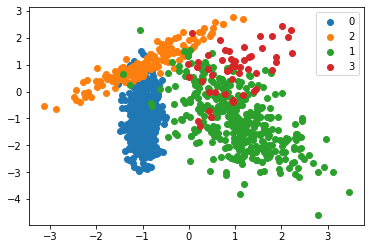

In [45]:
for label, _ in Counter(y).items():
    row_ix = where(y == label)
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label = str(label))
plt.legend()
plt.show()

In [46]:
over = SMOTE()
m,n = over.fit_resample(X,y)
Counter(n)

Counter({0: 450, 2: 450, 1: 450, 3: 450})

In [50]:
over = SMOTE(sampling_strategy = {0 : 450, 1 : 350, 2: 200, 3 : 100})
m,n = over.fit_resample(X,y)
Counter(n)

Counter({0: 450, 2: 200, 1: 350, 3: 100})

In [53]:
under = RandomUnderSampler(sampling_strategy = {0 : 400, 1 : 300, 2: 150, 3 : 50})
m,n = under.fit_resample(X,y)
Counter(n)

Counter({0: 400, 1: 300, 2: 150, 3: 50})